# Two-level system with Metropolis algorithm

We saw that the two level system can be solved analytically and by the direct sampling the probability distribution of the energy $p(E)$.
To take confidence with Metropolis algorithm, here we also try to simulate the system with this latter method.

We want to generate samples of configurations of particles $\vec{\mu} = (\mu_1, \ldots, \mu_N)$, where $\mu_i \in \{0,\epsilon\}$ are the two energy level for each particle.
Therefore we will sample the Boltzann distribution over the microstates $p(\vec{\mu})$ (instead of sampling the energy as for the direct sampling).

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Metropolis algorithm

The idea of Markov Chain Montecarlo is to jump around among the states of my systems (without enumerating all of them) by choosing the transition probabilities in such a way that the states that I get after each jump are samples that follow the probability distribution of the model.
In such a way only a very small subset of the states are visited, however, this subset is large enough to be used for reliable computation of macroscopic observables.


### 1 - One step of the Metropolis algorithm for the two-level model:

The following pseudocode provides a transition from one state (or configuration of the particle energues) , $\vec{\mu}$ to another, in a way that the detail balance of the resulting Markov Chain (where the states are all the spin configurations) is satisfied.
This is one step of the so-called Metropolis algorithm:

`Metropolis_step`($\vec{\mu}$, $\beta$, $\epsilon$):
> - Given the configuration $\vec{\mu}$, choose one of the $N$ particles at random, say $\mu_i$, and consider a new configuration $\vec{\mu}'$ such that the energy of $\mu_i$ is switched (from $0$ to $\epsilon$ or viceversa).
> - Compute the energy difference between the two states:
> \begin{equation}
\Delta E = \mathcal{H}\left( \vec{\mu}' \right) - \mathcal{H}\left( \vec{\mu} \right) = \mu_i' - \mu_i
\end{equation}
> Note that $\Delta E \in \{ -\epsilon, \epsilon \}$
> - If the energy of the new state is less than the previous one,  $\Delta E \le 0$, accept the new change (i.e. overwrite $\mu$: $\vec{\mu} \rightarrow \vec{\mu}'$), if not, accept the new change with probability $p = \exp[-\beta \Delta E]$.
> - Return $\vec{\sigma}$ 

Write the function `Metropolis_step`($\vec{\mu}$, $\beta$, $J$, $h$) that returns the new state (changed or unchanged depending on the Metropilis procedure).

In [2]:
def metropolis_step(state, beta, eps, N_part):
  chosen_part = np.random.randint(0,N_part)

  if state[chosen_part] == 0:
    if np.random.rand() < np.exp(-eps*beta):
      state[chosen_part] = 1
  else:
    state[chosen_part] = 0

  return state

### 2 - Plot the energy as a function of the Metropolis time

2a - First write a function that generate a random initial condition of particle energies, and than iterates the metropolis steps starting from that initial condition.

In [3]:
def energy_trajectory(beta, eps, N_part, max_time):
  state = np.random.randint(0, 2, N_part)
  traj = np.array([])
  for t in range(max_time):
    state = metropolis_step(state, beta, eps, N_part)
    traj = np.append(traj, state.sum()*eps)
  return traj

2b - Second generate an ensemble of these trajectories and compute the average over $R$ realizations.

Plot a generic trajectory and also the average energy as a function of time.

In [4]:
def energy_average_trajectory(beta, eps, N_part, max_time, n_realizations):

  average_traj = np.zeros(max_time)
  for _ in range(n_realizations):
    state = np.random.randint(0, 2, N_part)
    traj = energy_trajectory(beta, eps, N_part, max_time)
    average_traj += traj / n_realizations
  return average_traj

In [5]:
steps = 1000
N_part = 100
eps = 1
temp = 1

one_traj = energy_trajectory(1/temp, eps, N_part, steps)
av_E_traj = energy_average_trajectory(1/temp, eps, N_part, steps, 200)

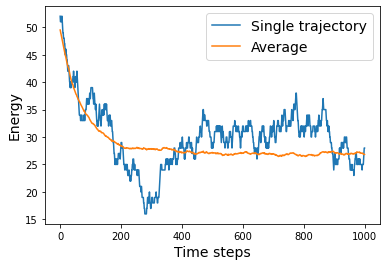

In [6]:
plt.xlabel('Time steps', fontsize=14)
plt.ylabel('Energy', fontsize=14)
plt.plot(one_traj, label='Single trajectory')
plt.plot(av_E_traj, label='Average')
plt.legend(fontsize=14)

From the previous plot you can have now an estimate of the time required for the equilibration of the system (that reaches the stationary state and the probability distribution is sampled).
We call this time `burn_in_time`

### 3 - Find the correlation length

All the nice results about the Montecarlo sample average and its convergence to the true average holds only if the samples are independent.
Actually MCMC generates correlated samples that loose correlation only after sufficient time.

To find how much time the chain needs to loose correlation you can plot the temporal autocorrelation for the energy:
$$
\rho(t_1, t_2) = \frac{\langle E_{t_1} E_{t_2} \rangle - \langle E_{t_1}\rangle \langle E_{t_2} \rangle  }{\text{std}(E_{t_1})\text{std}(E_{t_2})}
$$

As before, plot the autocorrelation as a function of time to get the `correlation_time` that you have to wait so that your samples will be independent.

Note: to compute the autocorrelation consider trajectories that are at equilibrium, therefore discard all the samples before the burn_in_time.

In [7]:
def energy_autocorrelation(beta, eps, N_part, max_time, burn_in_time, n_realizations):

  # Init the magnetiz product, the first and the second moments
  prod = np.zeros(max_time)
  average_at_start = 0
  average_at_next = np.zeros(max_time)
  sec_moment_at_start = 0
  sec_moment_at_next = np.zeros(max_time)
  
  for _ in range(n_realizations):

    # Equilibration
    state = np.random.randint(0, 2, N_part)
    for _ in range(burn_in_time):
      state = metropolis_step(state, beta, eps, N_part)

    # The start value is computed after the burn-in period.
    start_e = state.sum()*eps
    average_at_start += start_e / n_realizations
    sec_moment_at_start += start_e * start_e / n_realizations

    # Storing the value of all the magnetizations after the burn-in
    traj = np.array([])
    for _ in range(burn_in_time, burn_in_time + max_time):
      state = metropolis_step(state, beta, eps, N_part)
      traj = np.append(traj, state.sum()*eps)

    # Computing the statistical variables 
    prod += start_e * traj / n_realizations
    average_at_next += traj / n_realizations
    sec_moment_at_next += traj*traj / n_realizations

  std_start = np.sqrt(sec_moment_at_start - average_at_start**2)
  std_next = np.sqrt(sec_moment_at_next - average_at_next**2)
  return (prod - average_at_next*average_at_start) / std_start / std_next

In [8]:
steps = 1000
burn_in_time = 300
N_part = 100
eps = 1
temperatures = [0.5,1,5]

autocorr = []
for temp in temperatures:
  autocorr.append(energy_autocorrelation(1/temp, eps, N_part, steps, burn_in_time, 1000))

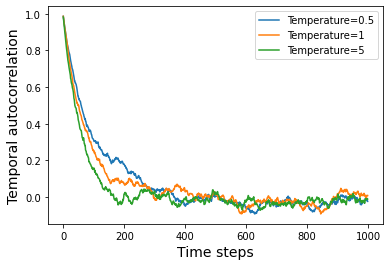

In [9]:
plt.xlabel('Time steps', fontsize=14)
plt.ylabel('Temporal autocorrelation', fontsize=14)
for i in range(len(temperatures)):
  plt.plot(autocorr[i], label="Temperature={}".format(temperatures[i]))
plt.legend()

### 4 - Compute the average energy as a function of the temperature

Now we have all the ingredients to simulate the model through Metropolis. The aim of this simulation is to estimate the average energy using the sample average:
$$
\langle E \rangle = \frac{1}{N} \sum_{k=1}^N E(\vec{\mu})
$$
where the samples $\vec{\mu}$ are generated through the Metropolis algorithm which starts to sample after a given `burn-in` period and, to remove correlations, discards several state of the chain.

A pseudocode can be:
> - Init the average magnetization $\langle E \rangle=0$.
> - Generate a random initial state $\mu$
> - Iterate the chain $i = 1, \ldots, t_{\text{burn-in}}$ (**equilibration**):
>> - Update the states without updating the energy $\mu$ = `metropolis_step`($\mu$, $\beta$, $\epsilon$)
> - Interate over the number of samples $i = 1, \ldots, N$:
>> - Iterate the chain $i = 1, \ldots, t_{\text{corr}}$ (**independence**):
>>> - Update the states without updating the energy $\mu$ = `metropolis_step`($\mu$, $\beta$, $\epsilon$)
>> - Compute the energy at the current $\vec{\mu}$ and uptate the average $\langle E \rangle = \langle E \rangle + E(\vec{\mu}) / N$
>- Return $\langle E \rangle$

Try to implement this code into a function that given the arguments N_particles, beta, $\epsilon$, N_samples, t_burn_in, t_correlation, returns the average energy.

In [10]:
def metropolis_two_level(N_part, beta, eps, N_samples, t_burn_in, t_correlation):

  energy = np.array([])
  generated_samples = 0

  # Equilibration
  state = np.random.randint(0, 2, N_part)
  for _ in range(t_burn_in):
    state = metropolis_step(state, beta, eps, N_part)

  energy = np.append(energy, state.sum()*eps)
  generated_samples += 1

  while generated_samples <= N_samples:

    # Discarding correlated samples
    for _ in range(t_correlation):
      state = metropolis_step(state, beta, eps, N_part)

    energy = np.append(energy, state.sum()*eps)
    generated_samples += 1

  return energy.mean()

When you have the code to compute the average energy, you can do it for different temperatures and plt the curve energy-temperature.
Compare the curve with the theoretical prediction.

In [11]:
import sys

def energy_curve(N_part, eps, temperatures, N_samples, t_burn_in, t_correlation):
  av_ene = np.array([])
  for t in temperatures:
    av_ene = np.append(av_ene, metropolis_two_level(N_part, 1/t, eps, N_samples, t_burn_in, t_correlation))
    sys.stdout.write("\rTemperature: {:.2f}/{:.2f} done, energy: {:.2f}".format(t, temperatures[-1], av_ene[-1]))
    sys.stdout.flush()
  return av_ene

In [30]:
N_part = 100
eps = 1
N_samples = 50
t_burn_in = 300
t_correlation = 300
temperatures = np.linspace(0.1, 10, 50)

energies = energy_curve(N_part, eps, temperatures, N_samples, t_burn_in, t_correlation)

Temperature: 10.00/10.00 done, energy: 47.27

In [31]:
def th_energy(temp, eps, N_part):
  return eps*N_part / (1 + np.exp( eps/temp ))

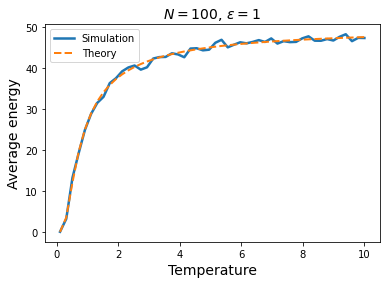

In [32]:
plt.xlabel('Temperature', fontsize=14)
plt.ylabel('Average energy', fontsize=14)
plt.title(r'$N={}$, $\epsilon={}$'.format(N_part, eps,), fontsize=14)
plt.plot(temperatures, energies, lw=2.5, label='Simulation')
plt.plot(temperatures, th_energy(temperatures, eps, N_part), ls='--', lw=2, label='Theory')

plt.legend()